# Data Visualization Program

### Figure 1:
* Expt design schematic
* Expt design patterns in space and time
* Example set of traces
* Calib of stimuli: desensitization
* Control for CA3 responses to patterns.
* CA3 heatmap
* CA3 analysis with respect to freq
* CA3 expected pattern response

### Figure 2:
* Deconv to extract of STP from trace: Schematic
* Comparison between deconv fit, P2P, and peak fitting
* Fitting of reference trace
* Example deconv and fit thereof.
* STP traces under different conditions: E/I, #sq and frequency
* Diversity in STP traces.

[<img src="notes_figures/Figure_outline_Fig2.jpg" width="500"/>]

### Figure 3:
* Model schematic for plasticity
* Fitting free params of model for E and I
* Fitting diversity for E and I
* Fitting stochasticity for E and I
* How averaged are E and I respectively? Crucial for escape calculation.

### Figure 4:
* Model integration: schematic of chem and elec components
* Model validation 1: Match to random pattern sequence
* Model validation 2: Match to Curr clamp recordings

### Figure 5
* Example E-I traces over a burst (train)
* E/I ratio of successive pulses across freq and numSq
* Summary figure across cells
Note: This figure should explain why we dont see escape from E-I balance
*Current clamp summary
 
### Figure 6: Why no escape
* Comparison of current clamp response with response generated from a model cell with summated E-I currents
Likely reason: inhibition builds up slowly during the train

### Figure 7: SDN across pulses for frequencies
* Example plot of SDN
* Grid
* Heatmap of gamma

[<img src="notes_figures/Figure_Outline_Fig7_SDN.jpg" width="500"/>]

### Figure 8: Estimations of Sparsity/Overlap from model vs obs
* Example trace vs model
* Estimation of sparsity/overlap from CA3 recordings

(Paper Figures 5 6 and 7)

[<img src="notes_figures/Figure_Outline_Fig5_6_7_May2023.png" width="500"/>]

### Some other ideas
1. SDN across frequencies: The envelope of E and I change with frequency of stimulation
2. relationship of peak of PSCs with the fall tau for both E and I
3. SDN expected vs observed plotted for different frequencies and consecutive pulse # 

In [46]:
import sys
import os
import importlib
from pathlib import Path
import pickle

import numpy as np
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import seaborn as sns
# sns.set_context('talk')
# import plotly.express as px
# import plotly.graph_objects as go

from scipy.signal import filter_design
from scipy.signal import butter, bessel, decimate, sosfiltfilt
from scipy.signal import find_peaks, peak_widths

%matplotlib widget


%tb
from eidynamics import utils, data_quality_checks, ephys_classes, plot_tools, expt_to_dataframe
# from eidynamics import plot_tools, utils
from eidynamics import pattern_index
import parse_data
import all_cells

# make a colour map viridis
viridis = sns.color_palette("viridis", 10)
flare = sns.color_palette("flare", 4)
crest = sns.color_palette("crest", 4)

color_squares = {1:viridis[0], 5:viridis[4], 15:viridis[8]}
color_EI = {'E':flare[0], 'I':crest[0]}
color_E = flare
color_I = crest

FileNotFoundError: [Errno 2] No such file or directory: '\\paper_figures\\Figure1.png'

### Path

In [45]:
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\")
data_path                    = Path(r"parsed_data\\")

### Data

In [4]:
# Frequency Sweep Protocol - Current Clamp
freq_sweep_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_combined_short.h5" 
df2 = pd.read_hdf(freq_sweep_datapath, key='data')
df2 = df2[ pd.notnull(df2['peaks_cell'])] # remove all sweeps that had NaNs in analysed params (mostly due to bad pulse detection)

freq_sweep_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_CC_long.h5" 
df = pd.read_hdf(freq_sweep_datapath, key='data')
df = df[ pd.notnull(df['peaks_cell'])] # remove all sweeps that had NaNs in analysed params (mostly due to bad pulse detection)

In [5]:
cc_cells = np.unique(df['cellID'])

In [6]:
# Load CA3 data
df_CA3_props = pd.read_csv(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\23-06-06_GrikAA316\3161\CA3_recording_3161_response_properties.csv")

In [7]:
# DataFrame metadata columns
metadata_columns = 49
metadata_fields = (df.iloc[:2,:metadata_columns].columns).to_list()

---

#### Figure 1

* Expt design schematic
* Expt design patterns in space and time
* Example set of traces
* Calib of stimuli: desensitization
* Control for CA3 responses to patterns.
* CA3 heatmap
* CA3 analysis with respect to freq
* CA3 expected pattern response

Plotting all 4 signals on a single plot


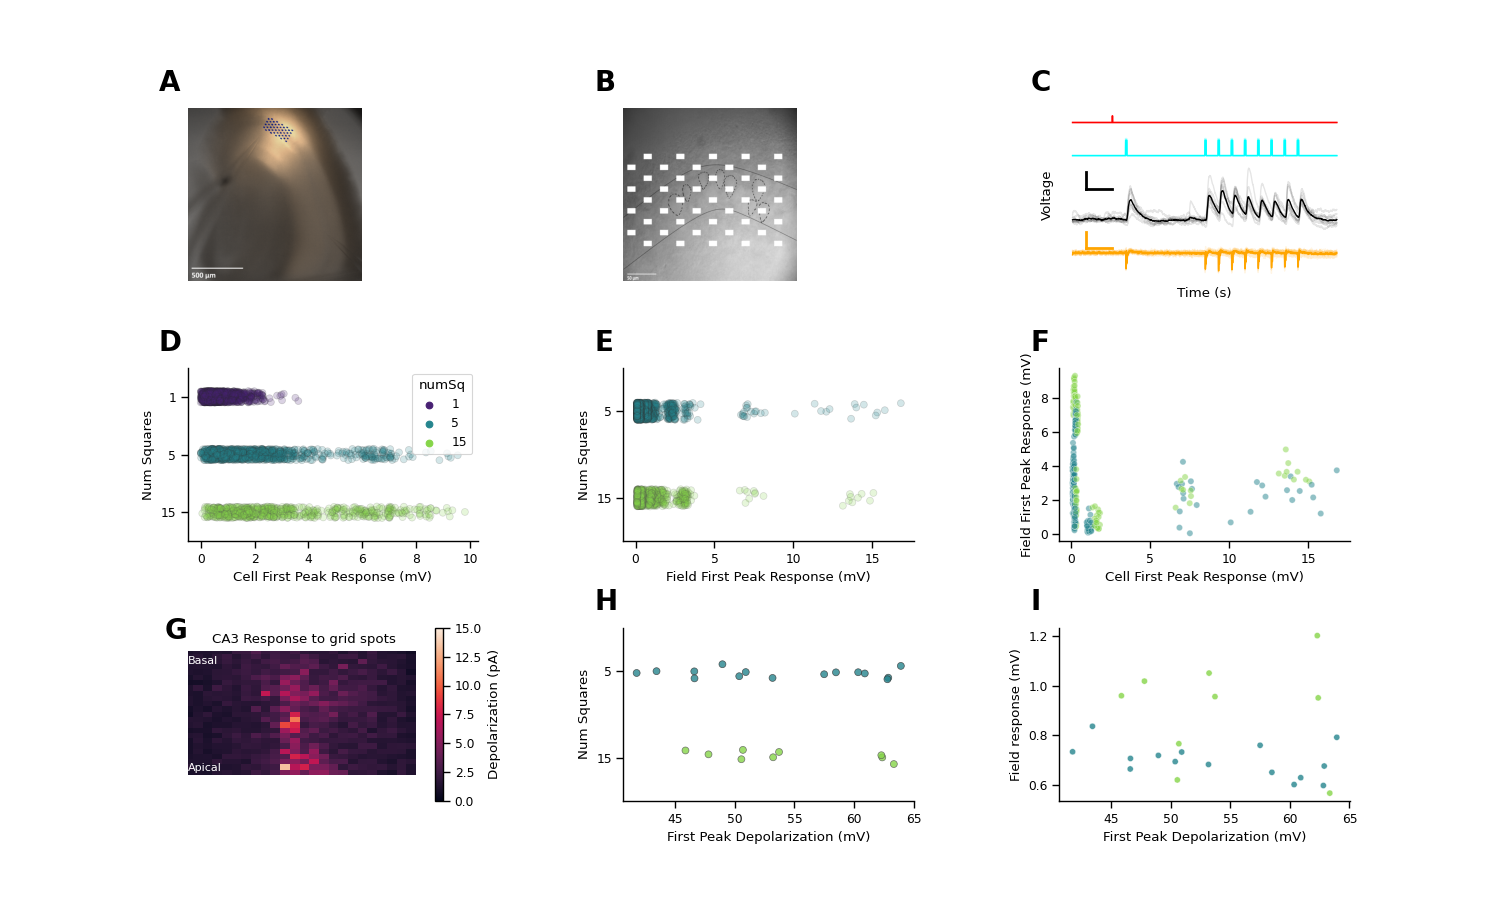

In [47]:
plt.close('all')

# aspect ration of the figure = 1
w, h = [15, 9]

fig1, [[ax1a, ax1b, ax1c],[ax1d, ax1e, ax1f],[ax1g, ax1h, ax1i]] = plt.subplots(3,3, figsize=(w, h),)
# have more space between suplots
fig1.subplots_adjust(hspace=0.5, wspace=0.5)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Fig 1A: Slice, polygon projection, and recording electrodes
ax1a.text(-0.1, 1.1, 'A', transform=ax1a.transAxes, size=20, weight='bold')
image1_path = all_cells.project_path_root / r"Lab\Projects\EI_Dynamics\Analysis\paper_figure_matter\slice_electrode_expression_cropped_with_scalebar_blue_polygon.png"
im1 = Image.open(image1_path)
# get the size of the image
im1_width, im1_height = im1.size
# get the aspect ratio of the ax1a axes object
ax1a_ratio = ax1a.get_window_extent().width / ax1a.get_window_extent().height
# change the axis limits so that verticle side of the image fits the axis and horizontal side is aligned left on the axis
ax1a.set_ylim(0, im1_height)
ax1a.set_xlim(0, im1_height*ax1a_ratio)
# plot the image
ax1a.imshow(im1, extent=[0, im1_width, 0, im1_height], aspect=1)
ax1a.axis('off')

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Fig 1B: Grid Pattern in Space overlaid on CA3 slice at 40x
ax1b.text(-0.1, 1.1, 'B', transform=ax1b.transAxes, size=20, weight='bold')
image2_path = all_cells.project_path_root / r'Lab\Projects\EI_Dynamics\Analysis\paper_figure_matter\CA3-polygonFrame_figure_with_cellboundaries.png'
im2 = Image.open(image2_path)
im2_width, im2_height = im2.size
# ax1b.imshow(im2)

ax1b.set_ylim(0, im1_height)
ax1b.set_xlim(0, im1_height*ax1a_ratio)
ax1b.imshow(im2, extent=[0, im1_width, 0, im1_height], aspect=1)
ax1b.axis('off')
# ax1b.set_anchor('W')

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Fig 1C: Protocol Freq Sweep
sample_cell = 1941
ax1c.text(-0.1, 1.1, 'C', transform=ax1c.transAxes, size=20, weight='bold')
data = df[(df['cellID'] == sample_cell) & (df['numSq']==15) &  (df['stimFreq']==20)]
fig1, ax1c = plot_tools.plot_data_from_df(data, data_start_column=49,combine=True, simplify=True, fig=fig1, ax=ax1c, exclude_from_simplification=[])
# set legend inside the plot
# ax1c.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), frameon=True) # legend removed to save space

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1D: First peak response
ax1d.text(-0.1, 1.1, 'D', transform=ax1d.transAxes, size=20, weight='bold')
# ax1d.set_title('First Peak Response')
df_temp = df2[ (df2['cell_fpr']<10) & (df2['cell_fpr']>0) & (df2['clampMode']=='CC')]#

# # have few ticks on x axis
# ax1d.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
# sns.histplot(data=df_temp, x="cell_fpr", ax=ax1d, kde=True, hue='numSq', palette='viridis', stat="density", common_norm=False,)
sns.stripplot(data=df_temp, x="cell_fpr", y='numSq', ax=ax1d, hue='numSq', palette=color_squares, jitter=True, s=5, alpha=0.2, orient="h", linewidth=0.5)
ax1d.set_xlabel('Cell First Peak Response (mV)')
ax1d.set_ylabel('Num Squares')
# remove top and right spines
ax1d.spines['top'].set_visible(False)
ax1d.spines['right'].set_visible(False)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1E: Field FPR histogram
ax1e.text(-0.1, 1.1, 'E', transform=ax1e.transAxes, size=20, weight='bold')
# plot a relationship between field_fpr and field_stpr using a scatter plot
df_temp = df2[ (df2['field_fpr']!= 0.0) ] 
# ax1e.set_title('Field First Peak Response')
sns.stripplot(data=df_temp, x="field_fpr", y='numSq', ax=ax1e, hue='numSq', palette=color_squares, jitter=True, s=5, alpha=0.2, orient="h", linewidth=0.5)
ax1e.set_xlabel('Field First Peak Response (mV)')
ax1e.set_ylabel('Num Squares')
# legend off
ax1e.legend([],[], frameon=False)
# remove top and right spines
ax1e.spines['top'].set_visible(False)
ax1e.spines['right'].set_visible(False)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1F: relationship between cell_fpr and field_fpr
ax1f.text(-0.1, 1.1, 'F', transform=ax1f.transAxes, size=20, weight='bold')
df_temp = df2[ (df2['cell_fpr']<10) & (df2['cell_fpr']>0) & (df2['clampMode']=='CC') & (df2['field_fpr']!=0)] #& (df2['field_fpr']<10)
sns.scatterplot(df_temp, x="field_fpr", y="cell_fpr", hue='numSq', palette=color_squares, ax=ax1f, alpha=0.5, s=20, legend=True)
ax1f.set_xlabel('Cell First Peak Response (mV)')
ax1f.set_ylabel('Field First Peak Response (mV)')
# legend off
ax1f.legend([],[], frameon=False)
# remove top and right spines
ax1f.spines['top'].set_visible(False)
ax1f.spines['right'].set_visible(False)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1G: CA3 heatmap
# import heatmap data
df_CA3_heatmap = pd.read_hdf(r"parsed_data\CA3_recording_3161_grid_response_pivot.h5")

grid_aspect_ratio = pattern_index.polygon_frame_properties['aspect_ratio']
ax1g.text(-0.1, 1.1, 'G', transform=ax1g.transAxes, size=20, weight='bold')


h = 8
w = grid_aspect_ratio*h
# ax1g.suptitle('Peak Response to 9 pulses in 24 hexagonal grid squares', fontsize=16)

pulse =0
# get data from column=i and all rows
vals = df_CA3_heatmap[pulse].values
# get index values
idx = (df_CA3_heatmap[pulse].index.get_level_values(0).values) - 1

# make heatmaps
plot_tools.plot_grid(spot_locs=idx, spot_values=vals, grid=[24,24], cmap='rocket', ax=ax1g, vmax=15)

# add text to the plot on top left corner of the heatmap in white color
ax1g.text(0.0, 0.9, 'Basal', transform=ax1g.transAxes, size=8,  color='white')
# add text to the plot on bottom left corner of the heatmap
ax1g.text(0.0, 0.05, 'Apical', transform=ax1g.transAxes, size=8, color='white')
ax1g.set_title('CA3 Response to grid spots')

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1H: CA3 pulse response
ax1h.text(-0.1, 1.1, 'H', transform=ax1h.transAxes, size=20, weight='bold')
df_temp = df2[ (df2['cellID']==3161) ]

# plot a relationship between cell_fpr and field_fpr using a scatter plot
sns.stripplot(data=df_temp, x="cell_fpr", y='numSq', ax=ax1h, hue='numSq', palette=color_squares, jitter=True, s=5, alpha=0.8, orient="h", linewidth=0.5)
# set labels
ax1h.set_xlabel('First Peak Depolarization (mV)')
ax1h.set_ylabel('Num Squares')
# legend off
ax1h.legend([],[], frameon=False)
# remove top and right spines
ax1h.spines['top'].set_visible(False)
ax1h.spines['right'].set_visible(False)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1I: CA3 cell_fpr vs field_fpr
ax1i.text(-0.1, 1.1, 'I', transform=ax1i.transAxes, size=20, weight='bold')
# change x-label
ax1i.set_xlabel('First Peak Optic Current (pA)')
# add scatterplot on ax1i
sns.scatterplot(data=df_temp, x="cell_fpr", y="field_fpr", hue='numSq', palette=color_squares, ax=ax1i, alpha=0.8, s=20, legend=True)
ax1i.set_xlabel('First Peak Depolarization (mV)')
ax1i.set_ylabel('Field response (mV)')
# legend off
ax1i.legend([],[], frameon=False)
# remove top and right spines
ax1i.spines['top'].set_visible(False)
ax1i.spines['right'].set_visible(False)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # save figure
figure_name = 'Figure1'
fig1.savefig(paper_figure_export_location / (figure_name + '.png'), dpi=300, bbox_inches='tight')
fig1.savefig(paper_figure_export_location / (figure_name + '.svg'), dpi=300, bbox_inches='tight')


### Figure 2: CA1 and CA3 responses to grid spots
* Deconv to extract of STP from trace: Schematic
* Comparison between deconv fit, P2P, and peak fitting
* Fitting of reference trace
* Example deconv and fit thereof.
* STP traces under different conditions: E/I, #sq and frequency
* Diversity in STP traces.

[<img src="notes_figures/Figure_outline_Fig2.jpg" width="500"/>]

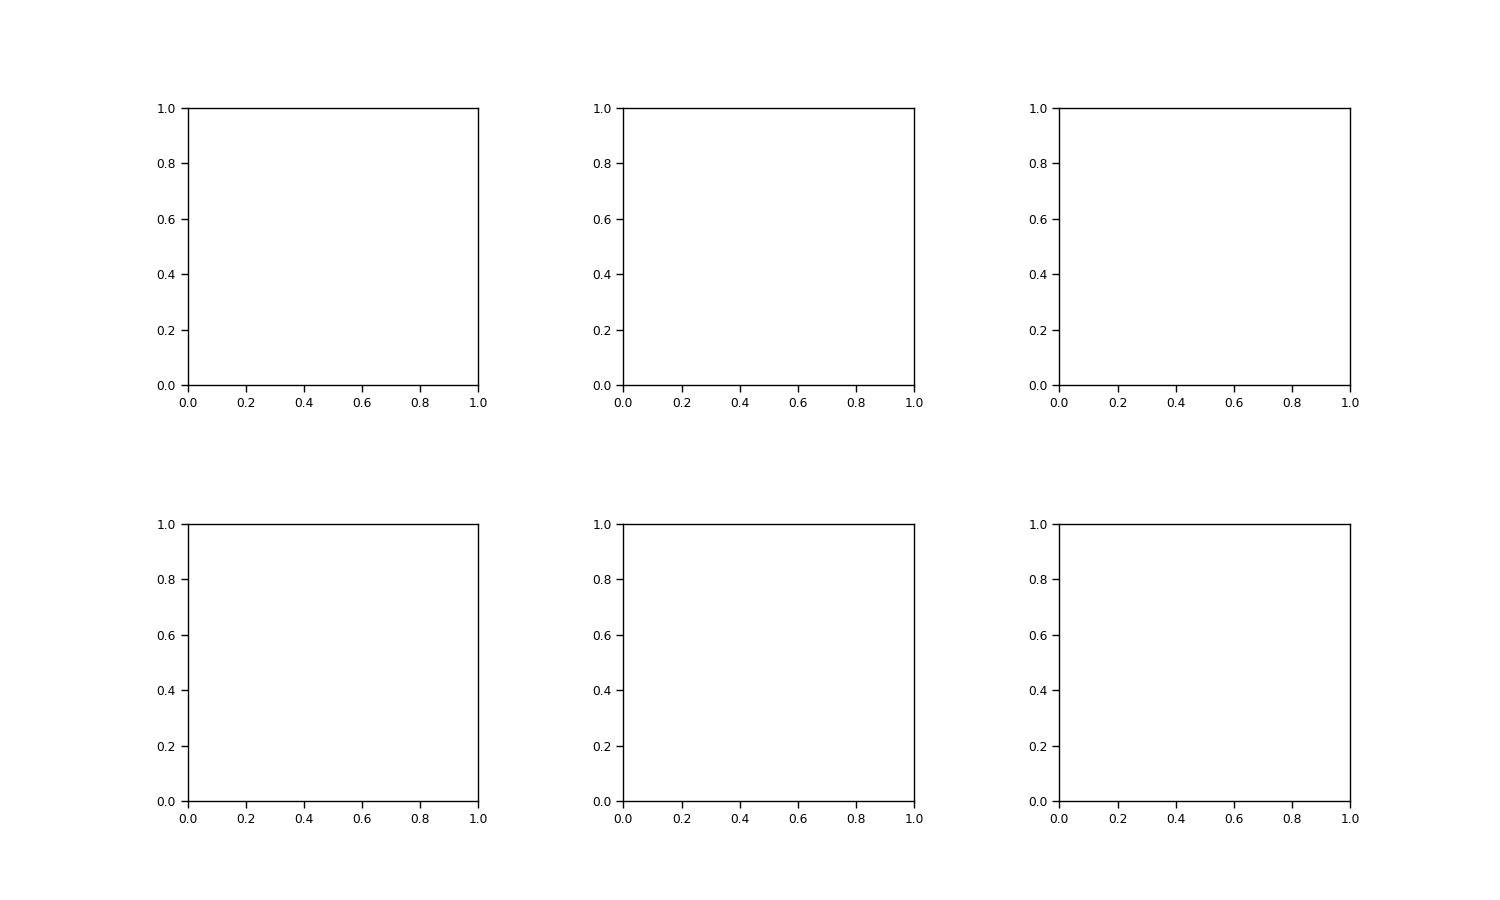

In [48]:
# aspect ration of the figure = 1
w, h = [15, 9]

fig2, [[ax2a, ax2b, ax2c],[ax2d, ax2e, ax2f]] = plt.subplots(2,3, figsize=(w, h),)
# have more space between suplots
fig2.subplots_adjust(hspace=0.5, wspace=0.5)



NameError: name 'cells' is not defined

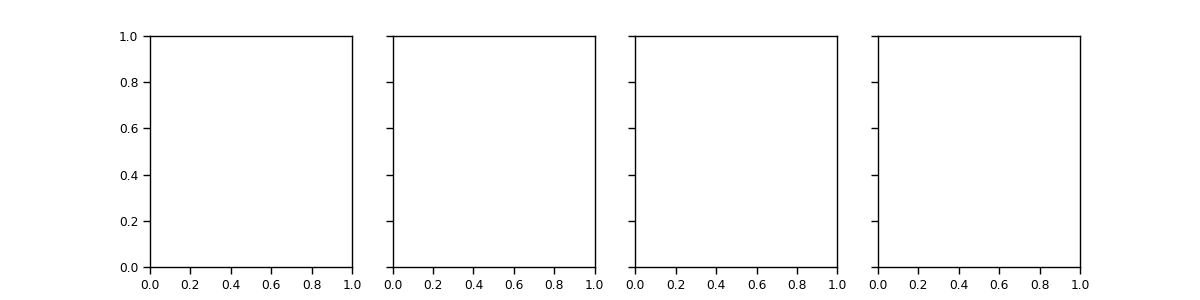

In [10]:
plt.close('all')
fig, ax = plt.subplots(1,4, figsize=(12, 3), sharey=True)
clrs = {1:colors[6], 5:colors[9], 15:colors[12]}
for c, cell in enumerate(cells):
    dff = df2[df2['cellID']==cell]

    # add fig suptitle with property name and cell name
    fig.suptitle('field response for all cells')
    for f,freq in enumerate([20,30,40,50]):
        dff2 = dff[dff['stimFreq']==freq]
        # add subplot title
        for j in range(dff2.shape[0]):
            sample_row = dff2.iloc[j,:]
            numSq = sample_row['numSq']
            field = sample_row['peaks_field'] / sample_row['peaks_field'][0]
            ax[f].plot(range(len(field)), field, linewidth=2.5, alpha=0.2, color=clrs[numSq], )
        


#     #save figure with filename containing cell name and prop name
# fig.savefig("all_CC_cells_field_response_p2p.png", dpi=300)
    # fig.show()

In [ ]:
fig2, ax2 = plt.subplots(2,2, figsize=(10, 6), )
x = np.linspace(0, 6.28, 1000)
y = np.sin(x)
z = np.gradient(y)


# plot 1: sine wave
ax2[0,0].plot(x, y, color='black', linewidth=2)

# plot 2: gradient
ax2[0,1].plot(x, z, color='black', linewidth=2)

# plot 3: sine wave with gradient
ax2[1,0].plot(x, y, color='black', linewidth=2)
ax2[1,0].plot(x, 50*z, color='red', linewidth=2)

# # plot 4: remove axis, add a new figure at its place and at 4 subfigures inside it
# axx = ax2[1,1]
# gridspec = axx.get_subplotspec().get_gridspec()
# axx.remove()



In [ ]:
def remove_axis_add_subfigures(fig, ax_to_remove=None, add_nrows=2, add_ncols=2):
    # remove the axis from the figure
    # for ax in ax_to_remove:
    ax_to_remove.remove()
    # add a new figure at the same place
    axx = fig.add_subplot(gridspec[1,1])
    # add subfigures inside the new figure
    axx_subfigs = []
    for i in range(add_nrows):
        for j in range(add_ncols):
            axx_subfigs.append(fig.add_subplot(gridspec[1,1]).subgridspec(add_nrows, add_ncols, i, j))
    return axx, axx_subfigs


In [ ]:
remove_axis_add_subfigures(fig2, ax_to_remove=ax2[1,1], add_nrows=3, add_ncols=2)

In [ ]:
fig = plt.figure()
gs0 = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs0[0])
ax2 = fig.add_subplot(gs0[1])
gssub = gs0[2].subgridspec(1, 3)
for i in range(3):
    fig.add_subplot(gssub[0, i])


x = (ax2.get_gridspec())    #Return the SubplotSpec associated with the subplot, or None.

